<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/cnn_colab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
pip install scikit-optimize

In [34]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [35]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim

# import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy

# Custom imports
# from feat_eng.funcs import add_min, safe_log, get_corr_feats, min_max
from custom_metrics.metrics import mean_error, lin_ccc, model_efficiency_coefficient

In [36]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [37]:
# ------------------- Read and prep data ------------------------------------ #


class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        super().__init__()

        """Initialize with X and y."""
        self.features = torch.from_numpy(features).permute(0, 3, 1, 2)
        self.targets = torch.from_numpy(targets)

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Generate one data sample."""

        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.features[idx].to(device), self.targets[idx].to(device)

features = np.load("data/cnn_features.npy")
targets = np.load("data/cnn_targets.npy")[:, 0]


# Train-val-test split 7-2-1
x_train_, x_test, y_train_, y_test = train_test_split(features, targets, test_size=2 / 10)
x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=2 / 8)

feature_reshaper = FunctionTransformer(
    func=np.reshape,
    inverse_func=np.reshape,
    kw_args={"newshape": (-1, 43)},
    inv_kw_args={"newshape": (-1, 15, 15, 43)},
)
feature_inverse_reshaper = FunctionTransformer(func=np.reshape, kw_args={"newshape": (-1, 15, 15, 43)})

target_reshaper = FunctionTransformer(func=np.reshape, kw_args={"newshape": (-1, 1)})

# Preprocessing
feature_transformer = Pipeline(
    steps=[
        ("reshaper", feature_reshaper),
        ("minmax_scaler", MinMaxScaler()),
        ("inverse_reshaper", feature_inverse_reshaper),
    ]
)
target_transformer = Pipeline(steps=[("reshaper", target_reshaper), ("minmax_scaler", MinMaxScaler())])

kfold_data = Dataset(feature_transformer.fit_transform(x_train_), target_transformer.fit_transform(y_train_))
# train_data = Dataset(feature_transformer.fit_transform(x_train), target_transformer.fit_transform(y_train))
# val_data = Dataset(feature_transformer.transform(x_val), target_transformer.transform(y_val))
# test_data = Dataset(feature_transformer.transform(x_test), target_transformer.transform(y_test))

# batch_size = 128

# train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, pin_memory=False)
# val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=2, pin_memory=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2, pin_memory=False)

In [38]:
# ------------------ CNN setup ---------------------------------------------- #


class CNN(nn.Module):
    """Neural Network class."""

    def __init__(self, conv1_channels=32, conv2_channels=64, linear1_neurons=64, linear2_neurons=32):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super().__init__()

        self.conv1_channels = conv1_channels
        self.conv2_channels = conv2_channels
        self.linear1_neurons = linear1_neurons
        self.linear2_neurons = linear2_neurons

        self.conv1 = nn.Conv2d(43, self.conv1_channels, kernel_size=3, stride=3)  # stride i stedet for maxpool
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(self.conv1_channels)
        self.conv2 = nn.Conv2d(self.conv1_channels, self.conv2_channels, 3)
        self.bn2 = nn.BatchNorm2d(self.conv2_channels)
        self.flat = nn.Flatten()
        self.fc1 = nn.LazyLinear(self.linear1_neurons)
        self.bn3 = nn.BatchNorm1d(self.linear1_neurons)
        self.fc2 = nn.Linear(self.linear1_neurons, self.linear2_neurons)
        self.bn4 = nn.BatchNorm1d(self.linear2_neurons)
        self.out = nn.Linear(self.linear2_neurons, 1)


    def forward(self, x):
        x.to(device)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.fc2(x)
        x = self.bn4(x)
        x = self.out(x)

        return x  # prediction


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn, n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    # best_model = copy.deepcopy(model.state_dict())

    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets, optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f"Stopping after {epoch} epochs due to no improvement.")
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ", end="")
            print(f"Val Loss: {val_epoch_loss:.4}")

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [39]:
# ------------------- Cross-validation -------------------------------------- #


def kfold_cv_train(
    dataset,
    model,
    optimizer,
    loss_fn=nn.MSELoss(),
    n_splits=5,
    batch_size=128,
    n_epochs=2000,
    patience=100,
    shuffle=True,
    rng=SEED,
):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):

        # Print
        print(f"FOLD {fold}")
        print("--------------------------------")

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        # Train
        train_loss, val_loss = train_network(
            model=model,
            train_data=train_loader,
            val_data=val_loader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            n_epochs=n_epochs,
            patience=patience,
            print_progress=False,
        )
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses) / n_splits, train_loss, val_loss





Gaussian Process:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 1 started. Evaluating function at provided point.
FOLD 0
--------------------------------
Stopping after 105 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 186 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 138 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   1%|          | 1/100 [01:31<2:31:35, 91.87s/it]

Stopping after 119 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 91.8614
Function value obtained: 0.0194
Current minimum: 0.0194
Iteration No: 2 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 186 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 228 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 279 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 215 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   2%|▏         | 2/100 [03:55<2:55:26, 107.42s/it]

Stopping after 209 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 143.6912
Function value obtained: 0.0184
Current minimum: 0.0184
Iteration No: 3 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 117 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 209 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 275 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   3%|▎         | 3/100 [06:00<3:02:01, 112.59s/it]

Stopping after 222 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 124.6734
Function value obtained: 0.0172
Current minimum: 0.0172
Iteration No: 4 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 227 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 332 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 153 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   4%|▍         | 4/100 [08:34<3:20:04, 125.04s/it]

Stopping after 303 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 154.0921
Function value obtained: 0.0177
Current minimum: 0.0172
Iteration No: 5 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 132 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 276 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 182 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 240 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   5%|▌         | 5/100 [10:50<3:23:04, 128.26s/it]

Stopping after 224 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 135.7743
Function value obtained: 0.0178
Current minimum: 0.0172
Iteration No: 6 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 189 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 264 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 350 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 288 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   6%|▌         | 6/100 [13:53<3:47:03, 144.93s/it]

Stopping after 347 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 183.8217
Function value obtained: 0.0167
Current minimum: 0.0167
Iteration No: 7 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 393 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 241 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 266 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 324 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   7%|▋         | 7/100 [16:58<4:03:15, 156.94s/it]

Stopping after 222 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 184.9494
Function value obtained: 0.0167
Current minimum: 0.0167
Iteration No: 8 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 134 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 255 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 146 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 222 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   8%|▊         | 8/100 [18:58<3:43:24, 145.70s/it]

Stopping after 162 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 119.4767
Function value obtained: 0.0194
Current minimum: 0.0167
Iteration No: 9 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 277 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 151 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 271 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 253 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:   9%|▉         | 9/100 [21:28<3:43:07, 147.11s/it]

Stopping after 208 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 150.4161
Function value obtained: 0.0172
Current minimum: 0.0167
Iteration No: 10 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 163 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 198 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 270 epochs due to no improvement.
FOLD 4
--------------------------------






Gaussian Process:  10%|█         | 10/100 [23:35<3:31:28, 140.99s/it]

Stopping after 178 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 126.6929
Function value obtained: 0.0176
Current minimum: 0.0167
Iteration No: 11 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 185 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 255 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 422 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 105 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 327 epochs due to no improvement.






Gaussian Process:  11%|█         | 11/100 [26:23<3:41:08, 149.08s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 167.9664
Function value obtained: 0.0365
Current minimum: 0.0167
Iteration No: 12 started. Evaluating function at random point.
FOLD 0
--------------------------------
Stopping after 100 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 101 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 1460 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 100 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 100 epochs due to no improvement.






Gaussian Process:  12%|█▏        | 12/100 [30:23<4:18:32, 176.28s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 239.7544
Function value obtained: 0.0745
Current minimum: 0.0167
Iteration No: 13 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 219 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 247 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 284 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 162 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 162 epochs due to no improvement.






Gaussian Process:  13%|█▎        | 13/100 [32:42<3:59:41, 165.30s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 139.6764
Function value obtained: 0.0203
Current minimum: 0.0167
Iteration No: 14 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 124 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 129 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 188 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 148 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 155 epochs due to no improvement.






Gaussian Process:  14%|█▍        | 14/100 [34:19<3:27:16, 144.61s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 96.3359
Function value obtained: 0.0191
Current minimum: 0.0167
Iteration No: 15 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 103 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 102 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 100 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 821 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 102 epochs due to no improvement.






Gaussian Process:  15%|█▌        | 15/100 [36:58<3:30:56, 148.90s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 158.9017
Function value obtained: 0.1126
Current minimum: 0.0167
Iteration No: 16 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 116 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 265 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 259 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 273 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 233 epochs due to no improvement.






Gaussian Process:  16%|█▌        | 16/100 [39:26<3:28:19, 148.81s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 148.5845
Function value obtained: 0.0176
Current minimum: 0.0167
Iteration No: 17 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 159 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 231 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 253 epochs due to no improvement.






Gaussian Process:  17%|█▋        | 17/100 [41:35<3:17:36, 142.85s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 128.9706
Function value obtained: 0.0195
Current minimum: 0.0167
Iteration No: 18 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 180 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 234 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 147 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 165 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 128 epochs due to no improvement.






Gaussian Process:  18%|█▊        | 18/100 [43:27<3:02:30, 133.55s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 111.8326
Function value obtained: 0.0187
Current minimum: 0.0167
Iteration No: 19 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 101 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 102 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 100 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 101 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 100 epochs due to no improvement.






Gaussian Process:  19%|█▉        | 19/100 [44:33<2:33:04, 113.39s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 66.3663
Function value obtained: 0.0626
Current minimum: 0.0167
Iteration No: 20 started. Searching for the next optimal point.
FOLD 0
--------------------------------
FOLD 1
--------------------------------
Stopping after 101 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 100 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 102 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 102 epochs due to no improvement.






Gaussian Process:  20%|██        | 20/100 [49:43<3:49:41, 172.26s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 309.6318
Function value obtained: 0.0376
Current minimum: 0.0167
Iteration No: 21 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 151 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 332 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 277 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 107 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 253 epochs due to no improvement.






Gaussian Process:  21%|██        | 21/100 [52:08<3:36:12, 164.21s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 145.4094
Function value obtained: 0.0191
Current minimum: 0.0167
Iteration No: 22 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 398 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 131 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 105 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 111 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 105 epochs due to no improvement.






Gaussian Process:  22%|██▏       | 22/100 [54:00<3:12:55, 148.40s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 111.5094
Function value obtained: 0.0195
Current minimum: 0.0167
Iteration No: 23 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 193 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 293 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 401 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 103 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 462 epochs due to no improvement.






Gaussian Process:  23%|██▎       | 23/100 [57:09<3:26:09, 160.64s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 189.1999
Function value obtained: 48.3419
Current minimum: 0.0167
Iteration No: 24 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 302 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 660 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 368 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 293 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 431 epochs due to no improvement.






Gaussian Process:  24%|██▍       | 24/100 [1:01:35<4:03:28, 192.22s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 265.8929
Function value obtained: 0.0173
Current minimum: 0.0167
Iteration No: 25 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 299 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 285 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 196 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 173 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 315 epochs due to no improvement.






Gaussian Process:  25%|██▌       | 25/100 [1:04:20<3:49:55, 183.94s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 164.6214
Function value obtained: 0.0172
Current minimum: 0.0167
Iteration No: 26 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 163 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 153 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 206 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 213 epochs due to no improvement.






Gaussian Process:  26%|██▌       | 26/100 [1:06:16<3:21:56, 163.73s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 116.5774
Function value obtained: 0.0176
Current minimum: 0.0167
Iteration No: 27 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 180 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 271 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 241 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 154 epochs due to no improvement.






Gaussian Process:  27%|██▋       | 27/100 [1:08:25<3:06:22, 153.18s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 128.5663
Function value obtained: 0.0167
Current minimum: 0.0167
Iteration No: 28 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 181 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 234 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 285 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 215 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 261 epochs due to no improvement.






Gaussian Process:  28%|██▊       | 28/100 [1:10:59<3:04:05, 153.41s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 153.9574
Function value obtained: 0.0168
Current minimum: 0.0167
Iteration No: 29 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 131 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 323 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 203 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 353 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 320 epochs due to no improvement.






Gaussian Process:  29%|██▉       | 29/100 [1:13:52<3:08:35, 159.38s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 173.2923
Function value obtained: 0.0174
Current minimum: 0.0167
Iteration No: 30 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 122 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 199 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 163 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 219 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 230 epochs due to no improvement.






Gaussian Process:  30%|███       | 30/100 [1:15:54<2:52:56, 148.24s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 122.2475
Function value obtained: 0.0185
Current minimum: 0.0167
Iteration No: 31 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 217 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 378 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 256 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 132 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 305 epochs due to no improvement.






Gaussian Process:  31%|███       | 31/100 [1:18:42<2:57:09, 154.05s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 167.6039
Function value obtained: 0.0187
Current minimum: 0.0167
Iteration No: 32 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 264 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 234 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 106 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 214 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 265 epochs due to no improvement.






Gaussian Process:  32%|███▏      | 32/100 [1:21:03<2:50:19, 150.29s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 141.5192
Function value obtained: 0.0224
Current minimum: 0.0167
Iteration No: 33 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 140 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 250 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 210 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 195 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 153 epochs due to no improvement.






Gaussian Process:  33%|███▎      | 33/100 [1:23:05<2:38:17, 141.75s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 121.8261
Function value obtained: 0.0196
Current minimum: 0.0167
Iteration No: 34 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 103 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 108 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 283 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 104 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 252 epochs due to no improvement.






Gaussian Process:  34%|███▍      | 34/100 [1:24:56<2:25:39, 132.42s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 110.6570
Function value obtained: 0.0456
Current minimum: 0.0167
Iteration No: 35 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 206 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 167 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 219 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 227 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 277 epochs due to no improvement.






Gaussian Process:  35%|███▌      | 35/100 [1:27:17<2:26:15, 135.01s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 141.0317
Function value obtained: 0.0183
Current minimum: 0.0167
Iteration No: 36 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 128 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 232 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 171 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 178 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 295 epochs due to no improvement.






Gaussian Process:  36%|███▌      | 36/100 [1:29:26<2:22:09, 133.27s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 129.2270
Function value obtained: 0.0193
Current minimum: 0.0167
Iteration No: 37 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 318 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 296 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 323 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 358 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 365 epochs due to no improvement.






Gaussian Process:  37%|███▋      | 37/100 [1:33:00<2:45:11, 157.32s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 213.4396
Function value obtained: 0.0170
Current minimum: 0.0167
Iteration No: 38 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 165 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 237 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 255 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 234 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 291 epochs due to no improvement.






Gaussian Process:  38%|███▊      | 38/100 [1:35:31<2:40:39, 155.48s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 151.1698
Function value obtained: 0.0171
Current minimum: 0.0167
Iteration No: 39 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 124 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 146 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 264 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 150 epochs due to no improvement.






Gaussian Process:  39%|███▉      | 39/100 [1:37:23<2:24:47, 142.42s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 111.9503
Function value obtained: 0.0181
Current minimum: 0.0167
Iteration No: 40 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 149 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 145 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 290 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 152 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 192 epochs due to no improvement.






Gaussian Process:  40%|████      | 40/100 [1:39:21<2:15:18, 135.31s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 118.7246
Function value obtained: 0.0192
Current minimum: 0.0167
Iteration No: 41 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 131 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 221 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 169 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 174 epochs due to no improvement.






Gaussian Process:  41%|████      | 41/100 [1:41:16<2:06:55, 129.07s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 114.5179
Function value obtained: 0.0192
Current minimum: 0.0167
Iteration No: 42 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 127 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 216 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 265 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 252 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 232 epochs due to no improvement.






Gaussian Process:  42%|████▏     | 42/100 [1:43:38<2:08:39, 133.10s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 142.4997
Function value obtained: 0.0184
Current minimum: 0.0167
Iteration No: 43 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 195 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 226 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 227 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 308 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 275 epochs due to no improvement.






Gaussian Process:  43%|████▎     | 43/100 [1:46:16<2:13:33, 140.58s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 158.0273
Function value obtained: 0.0176
Current minimum: 0.0167
Iteration No: 44 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 116 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 228 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 105 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 210 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 360 epochs due to no improvement.






Gaussian Process:  44%|████▍     | 44/100 [1:48:29<2:08:59, 138.21s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 132.6736
Function value obtained: 15.8740
Current minimum: 0.0167
Iteration No: 45 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 244 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 253 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 190 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 405 epochs due to no improvement.






Gaussian Process:  45%|████▌     | 45/100 [1:51:11<2:13:09, 145.26s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 161.7126
Function value obtained: 0.0173
Current minimum: 0.0167
Iteration No: 46 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 139 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 285 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 166 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 279 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 349 epochs due to no improvement.






Gaussian Process:  46%|████▌     | 46/100 [1:53:48<2:14:02, 148.93s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 157.4898
Function value obtained: 0.0179
Current minimum: 0.0167
Iteration No: 47 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 208 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 354 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 318 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 166 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 305 epochs due to no improvement.






Gaussian Process:  47%|████▋     | 47/100 [1:56:42<2:18:12, 156.47s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 174.0739
Function value obtained: 0.0246
Current minimum: 0.0167
Iteration No: 48 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 209 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 207 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 166 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 145 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 207 epochs due to no improvement.






Gaussian Process:  48%|████▊     | 48/100 [1:58:43<2:06:22, 145.82s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 120.9766
Function value obtained: 0.0211
Current minimum: 0.0167
Iteration No: 49 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 280 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 206 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 301 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 107 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 284 epochs due to no improvement.






Gaussian Process:  49%|████▉     | 49/100 [2:01:14<2:05:11, 147.29s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 150.7128
Function value obtained: 0.0211
Current minimum: 0.0167
Iteration No: 50 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 166 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 227 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 259 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 223 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 204 epochs due to no improvement.






Gaussian Process:  50%|█████     | 50/100 [2:03:33<2:00:33, 144.67s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 138.5637
Function value obtained: 0.0170
Current minimum: 0.0167
Iteration No: 51 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 254 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 281 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 294 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 244 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 252 epochs due to no improvement.






Gaussian Process:  51%|█████     | 51/100 [2:06:23<2:04:32, 152.50s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 170.7627
Function value obtained: 0.0186
Current minimum: 0.0167
Iteration No: 52 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 304 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 431 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 406 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 547 epochs due to no improvement.






Gaussian Process:  52%|█████▏    | 52/100 [2:10:21<2:22:28, 178.09s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 237.7953
Function value obtained: 0.0185
Current minimum: 0.0167
Iteration No: 53 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 127 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 244 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 224 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 341 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 171 epochs due to no improvement.






Gaussian Process:  53%|█████▎    | 53/100 [2:12:44<2:11:05, 167.35s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 142.3032
Function value obtained: 0.0182
Current minimum: 0.0167
Iteration No: 54 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 139 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 161 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 144 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 165 epochs due to no improvement.






Gaussian Process:  54%|█████▍    | 54/100 [2:14:22<1:52:26, 146.67s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 98.4041
Function value obtained: 0.0197
Current minimum: 0.0167
Iteration No: 55 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 209 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 242 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 176 epochs due to no improvement.






Gaussian Process:  55%|█████▌    | 55/100 [2:16:26<1:44:54, 139.87s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 124.0150
Function value obtained: 0.0177
Current minimum: 0.0167
Iteration No: 56 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 126 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 249 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 239 epochs due to no improvement.






Gaussian Process:  56%|█████▌    | 56/100 [2:18:28<1:38:40, 134.57s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 122.1900
Function value obtained: 0.0189
Current minimum: 0.0167
Iteration No: 57 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 126 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 334 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 361 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 238 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 224 epochs due to no improvement.






Gaussian Process:  57%|█████▋    | 57/100 [2:21:13<1:43:01, 143.75s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 165.1761
Function value obtained: 0.0176
Current minimum: 0.0167
Iteration No: 58 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 147 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 223 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 255 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 199 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 327 epochs due to no improvement.






Gaussian Process:  58%|█████▊    | 58/100 [2:23:42<1:41:34, 145.10s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 148.2426
Function value obtained: 0.0170
Current minimum: 0.0167
Iteration No: 59 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 198 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 216 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 266 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 243 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 229 epochs due to no improvement.






Gaussian Process:  59%|█████▉    | 59/100 [2:26:10<1:39:48, 146.06s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 148.3067
Function value obtained: 0.0166
Current minimum: 0.0166
Iteration No: 60 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 239 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 263 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 247 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 197 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 324 epochs due to no improvement.






Gaussian Process:  60%|██████    | 60/100 [2:28:55<1:41:10, 151.75s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 165.0367
Function value obtained: 0.0177
Current minimum: 0.0166
Iteration No: 61 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 174 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 116 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 188 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 140 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 300 epochs due to no improvement.






Gaussian Process:  61%|██████    | 61/100 [2:30:53<1:32:03, 141.63s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 118.0052
Function value obtained: 0.0171
Current minimum: 0.0166
Iteration No: 62 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 191 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 150 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 179 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 199 epochs due to no improvement.






Gaussian Process:  62%|██████▏   | 62/100 [2:32:50<1:25:06, 134.38s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 117.4512
Function value obtained: 0.0179
Current minimum: 0.0166
Iteration No: 63 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 138 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 147 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 246 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 303 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 251 epochs due to no improvement.






Gaussian Process:  63%|██████▎   | 63/100 [2:35:09<1:23:44, 135.80s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 139.1275
Function value obtained: 0.0197
Current minimum: 0.0166
Iteration No: 64 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 157 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 183 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 193 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 190 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 164 epochs due to no improvement.






Gaussian Process:  64%|██████▍   | 64/100 [2:37:06<1:17:57, 129.93s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 116.2248
Function value obtained: 0.0164
Current minimum: 0.0164
Iteration No: 65 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 105 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 183 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 350 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 200 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 322 epochs due to no improvement.






Gaussian Process:  65%|██████▌   | 65/100 [2:39:36<1:19:18, 135.97s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 150.0698
Function value obtained: 0.0175
Current minimum: 0.0164
Iteration No: 66 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 145 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 181 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 146 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 250 epochs due to no improvement.






Gaussian Process:  66%|██████▌   | 66/100 [2:41:32<1:13:44, 130.13s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 116.5165
Function value obtained: 0.0179
Current minimum: 0.0164
Iteration No: 67 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 160 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 178 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 250 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 160 epochs due to no improvement.






Gaussian Process:  67%|██████▋   | 67/100 [2:43:35<1:10:25, 128.04s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 123.1585
Function value obtained: 0.0174
Current minimum: 0.0164
Iteration No: 68 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 103 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 108 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 114 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 111 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 110 epochs due to no improvement.






Gaussian Process:  68%|██████▊   | 68/100 [2:44:47<59:11, 111.00s/it]  /usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 71.2275
Function value obtained: 0.0212
Current minimum: 0.0164
Iteration No: 69 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 224 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 242 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 371 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 107 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 376 epochs due to no improvement.






Gaussian Process:  69%|██████▉   | 69/100 [2:47:38<1:06:45, 129.20s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 171.6816
Function value obtained: 0.0203
Current minimum: 0.0164
Iteration No: 70 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 177 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 193 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 246 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 200 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 180 epochs due to no improvement.






Gaussian Process:  70%|███████   | 70/100 [2:49:46<1:04:25, 128.85s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 128.0162
Function value obtained: 0.0191
Current minimum: 0.0164
Iteration No: 71 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 184 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 171 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 173 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 192 epochs due to no improvement.






Gaussian Process:  71%|███████   | 71/100 [2:51:43<1:00:28, 125.12s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 116.4124
Function value obtained: 0.0176
Current minimum: 0.0164
Iteration No: 72 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 217 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 205 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 235 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 103 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 388 epochs due to no improvement.






Gaussian Process:  72%|███████▏  | 72/100 [2:54:10<1:01:28, 131.75s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 147.2197
Function value obtained: 829.6858
Current minimum: 0.0164
Iteration No: 73 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 180 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 295 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 316 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 211 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 316 epochs due to no improvement.






Gaussian Process:  73%|███████▎  | 73/100 [2:57:00<1:04:24, 143.14s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 169.7283
Function value obtained: 0.0169
Current minimum: 0.0164
Iteration No: 74 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 190 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 215 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 182 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 249 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 190 epochs due to no improvement.






Gaussian Process:  74%|███████▍  | 74/100 [2:59:12<1:00:34, 139.80s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 132.0058
Function value obtained: 0.0175
Current minimum: 0.0164
Iteration No: 75 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 129 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 364 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 154 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 267 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 231 epochs due to no improvement.






Gaussian Process:  75%|███████▌  | 75/100 [3:01:39<59:08, 141.94s/it]  /usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 146.9350
Function value obtained: 0.0191
Current minimum: 0.0164
Iteration No: 76 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 158 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 155 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 153 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 175 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 215 epochs due to no improvement.






Gaussian Process:  76%|███████▌  | 76/100 [3:03:29<52:55, 132.32s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 109.8663
Function value obtained: 0.0181
Current minimum: 0.0164
Iteration No: 77 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 156 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 347 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 299 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 228 epochs due to no improvement.






Gaussian Process:  77%|███████▋  | 77/100 [3:06:05<53:32, 139.70s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 156.9037
Function value obtained: 0.0172
Current minimum: 0.0164
Iteration No: 78 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 196 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 265 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 245 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 182 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 218 epochs due to no improvement.






Gaussian Process:  78%|███████▊  | 78/100 [3:08:27<51:26, 140.29s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 141.6852
Function value obtained: 0.0172
Current minimum: 0.0164
Iteration No: 79 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 155 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 221 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 215 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 268 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 174 epochs due to no improvement.






Gaussian Process:  79%|███████▉  | 79/100 [3:10:41<48:25, 138.34s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 133.7952
Function value obtained: 0.0176
Current minimum: 0.0164
Iteration No: 80 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 124 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 137 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 152 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 206 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 254 epochs due to no improvement.






Gaussian Process:  80%|████████  | 80/100 [3:12:33<43:31, 130.56s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 112.3932
Function value obtained: 0.0177
Current minimum: 0.0164
Iteration No: 81 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 153 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 230 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 244 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 269 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 178 epochs due to no improvement.






Gaussian Process:  81%|████████  | 81/100 [3:14:52<42:06, 132.97s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 138.5867
Function value obtained: 0.0170
Current minimum: 0.0164
Iteration No: 82 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 184 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 208 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 157 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 154 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 227 epochs due to no improvement.






Gaussian Process:  82%|████████▏ | 82/100 [3:16:52<38:44, 129.13s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 120.1962
Function value obtained: 0.0193
Current minimum: 0.0164
Iteration No: 83 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 157 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 163 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 162 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 177 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 217 epochs due to no improvement.






Gaussian Process:  83%|████████▎ | 83/100 [3:18:45<35:13, 124.32s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 113.0879
Function value obtained: 0.0186
Current minimum: 0.0164
Iteration No: 84 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 141 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 159 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 222 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 188 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 211 epochs due to no improvement.






Gaussian Process:  84%|████████▍ | 84/100 [3:20:44<32:44, 122.79s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 119.2194
Function value obtained: 0.0179
Current minimum: 0.0164
Iteration No: 85 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 156 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 144 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 247 epochs due to no improvement.






Gaussian Process:  85%|████████▌ | 85/100 [3:22:39<30:06, 120.46s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 115.0187
Function value obtained: 0.0199
Current minimum: 0.0164
Iteration No: 86 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 120 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 167 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 207 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 181 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 243 epochs due to no improvement.






Gaussian Process:  86%|████████▌ | 86/100 [3:24:37<27:54, 119.60s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 117.5855
Function value obtained: 0.0165
Current minimum: 0.0164
Iteration No: 87 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 227 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 172 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 243 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 259 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 214 epochs due to no improvement.






Gaussian Process:  87%|████████▋ | 87/100 [3:27:01<27:29, 126.90s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 143.9490
Function value obtained: 0.0171
Current minimum: 0.0164
Iteration No: 88 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 212 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 210 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 248 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 175 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 253 epochs due to no improvement.






Gaussian Process:  88%|████████▊ | 88/100 [3:29:21<26:11, 130.99s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 140.5117
Function value obtained: 0.0188
Current minimum: 0.0164
Iteration No: 89 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 245 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 256 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 225 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 251 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 245 epochs due to no improvement.






Gaussian Process:  89%|████████▉ | 89/100 [3:32:00<25:30, 139.14s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 158.1525
Function value obtained: 0.0173
Current minimum: 0.0164
Iteration No: 90 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 122 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 176 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 363 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 196 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 293 epochs due to no improvement.






Gaussian Process:  90%|█████████ | 90/100 [3:34:28<23:38, 141.81s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 148.0641
Function value obtained: 0.0173
Current minimum: 0.0164
Iteration No: 91 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 301 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 185 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 196 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 211 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 187 epochs due to no improvement.






Gaussian Process:  91%|█████████ | 91/100 [3:36:48<21:11, 141.28s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 140.0412
Function value obtained: 0.0178
Current minimum: 0.0164
Iteration No: 92 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 172 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 286 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 202 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 189 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 302 epochs due to no improvement.






Gaussian Process:  92%|█████████▏| 92/100 [3:39:16<19:07, 143.49s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 148.6233
Function value obtained: 0.0176
Current minimum: 0.0164
Iteration No: 93 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 202 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 228 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 143 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 219 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 186 epochs due to no improvement.






Gaussian Process:  93%|█████████▎| 93/100 [3:41:23<16:09, 138.44s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 126.6645
Function value obtained: 0.0175
Current minimum: 0.0164
Iteration No: 94 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 251 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 162 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 160 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 163 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 155 epochs due to no improvement.






Gaussian Process:  94%|█████████▍| 94/100 [3:43:19<13:10, 131.82s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 116.3900
Function value obtained: 0.0184
Current minimum: 0.0164
Iteration No: 95 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 142 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 182 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 285 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 288 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 278 epochs due to no improvement.






Gaussian Process:  95%|█████████▌| 95/100 [3:45:52<11:29, 137.96s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 152.2748
Function value obtained: 0.0165
Current minimum: 0.0164
Iteration No: 96 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 166 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 189 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 214 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 206 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 333 epochs due to no improvement.






Gaussian Process:  96%|█████████▌| 96/100 [3:48:14<09:17, 139.36s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 142.6412
Function value obtained: 0.0169
Current minimum: 0.0164
Iteration No: 97 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 170 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 242 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 182 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 160 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 253 epochs due to no improvement.






Gaussian Process:  97%|█████████▋| 97/100 [3:50:24<06:49, 136.39s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 129.4603
Function value obtained: 0.0174
Current minimum: 0.0164
Iteration No: 98 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 172 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 196 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 265 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 255 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 195 epochs due to no improvement.






Gaussian Process:  98%|█████████▊| 98/100 [3:52:44<04:34, 137.41s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 139.7946
Function value obtained: 0.0170
Current minimum: 0.0164
Iteration No: 99 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 177 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 149 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 185 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 326 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 181 epochs due to no improvement.






Gaussian Process:  99%|█████████▉| 99/100 [3:54:56<02:15, 135.79s/it]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 131.9946
Function value obtained: 0.0173
Current minimum: 0.0164
Iteration No: 100 started. Searching for the next optimal point.
FOLD 0
--------------------------------
Stopping after 168 epochs due to no improvement.
FOLD 1
--------------------------------
Stopping after 187 epochs due to no improvement.
FOLD 2
--------------------------------
Stopping after 192 epochs due to no improvement.
FOLD 3
--------------------------------
Stopping after 250 epochs due to no improvement.
FOLD 4
--------------------------------
Stopping after 175 epochs due to no improvement.






Gaussian Process: 100%|██████████| 100/100 [3:57:02<00:00, 132.85s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 125.9804
Function value obtained: 0.0173
Current minimum: 0.0164


[0.0040766469999379135, 0.06041389403147942, 125, 128, 128, 22]

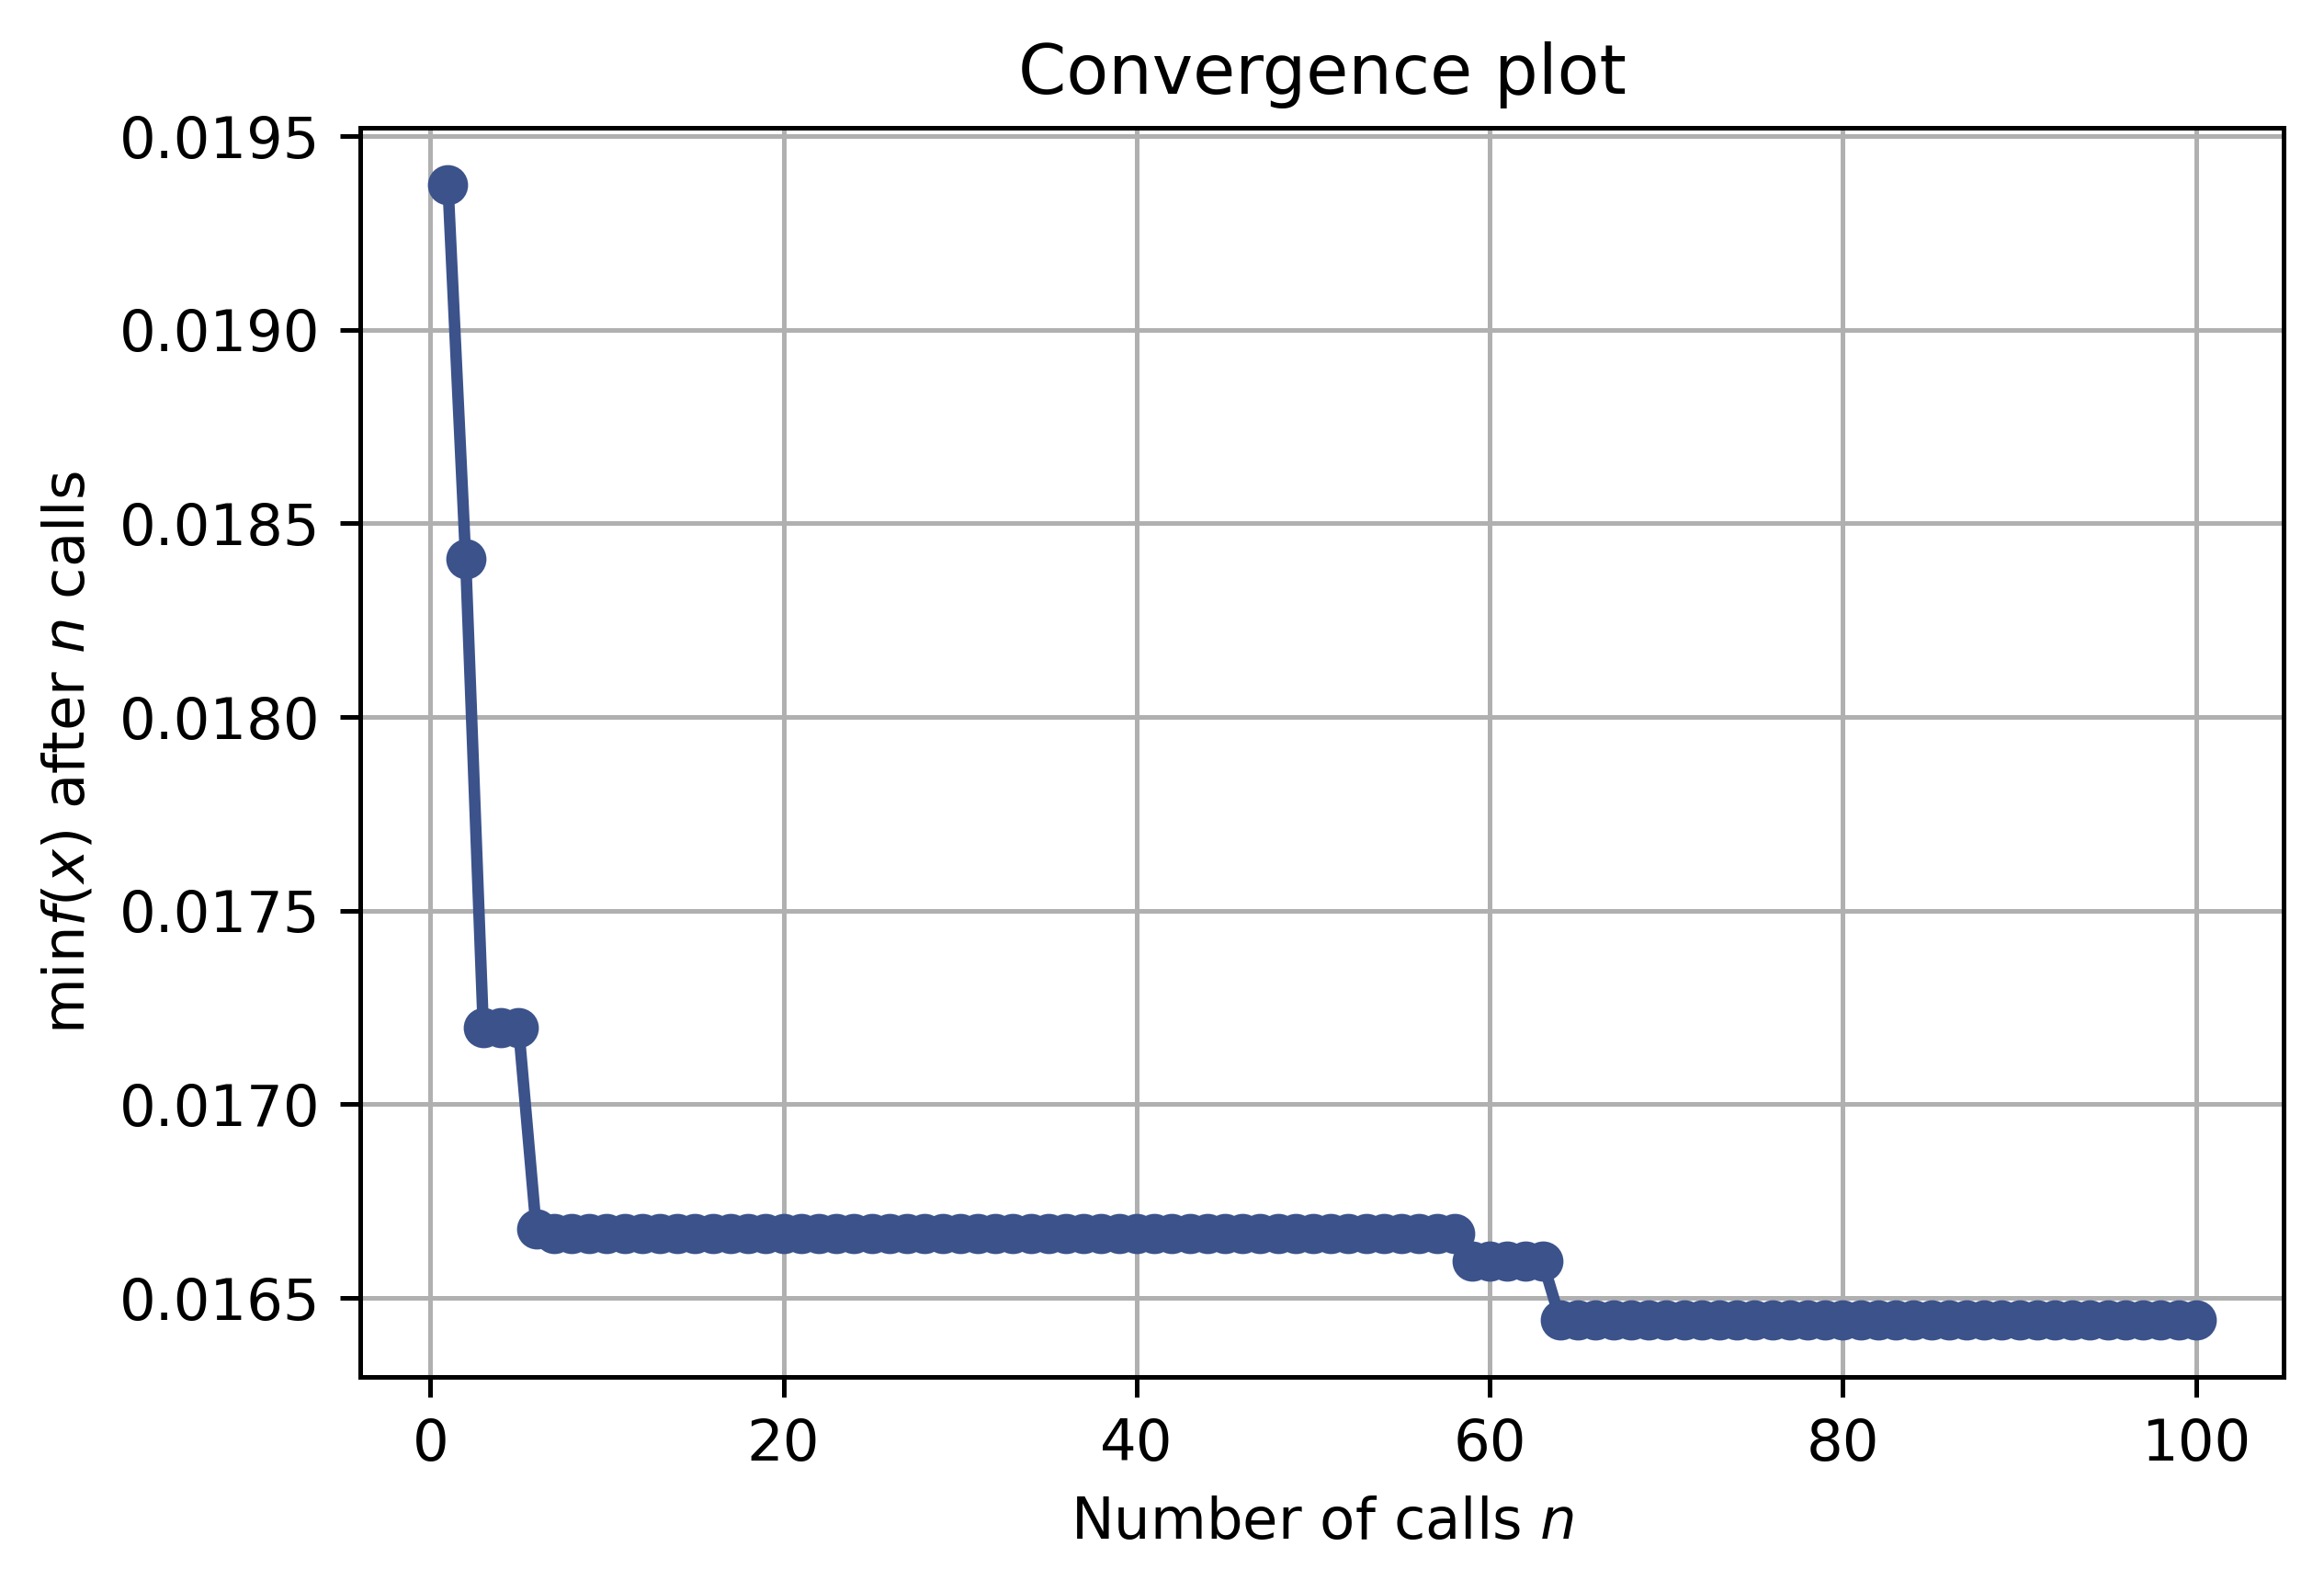

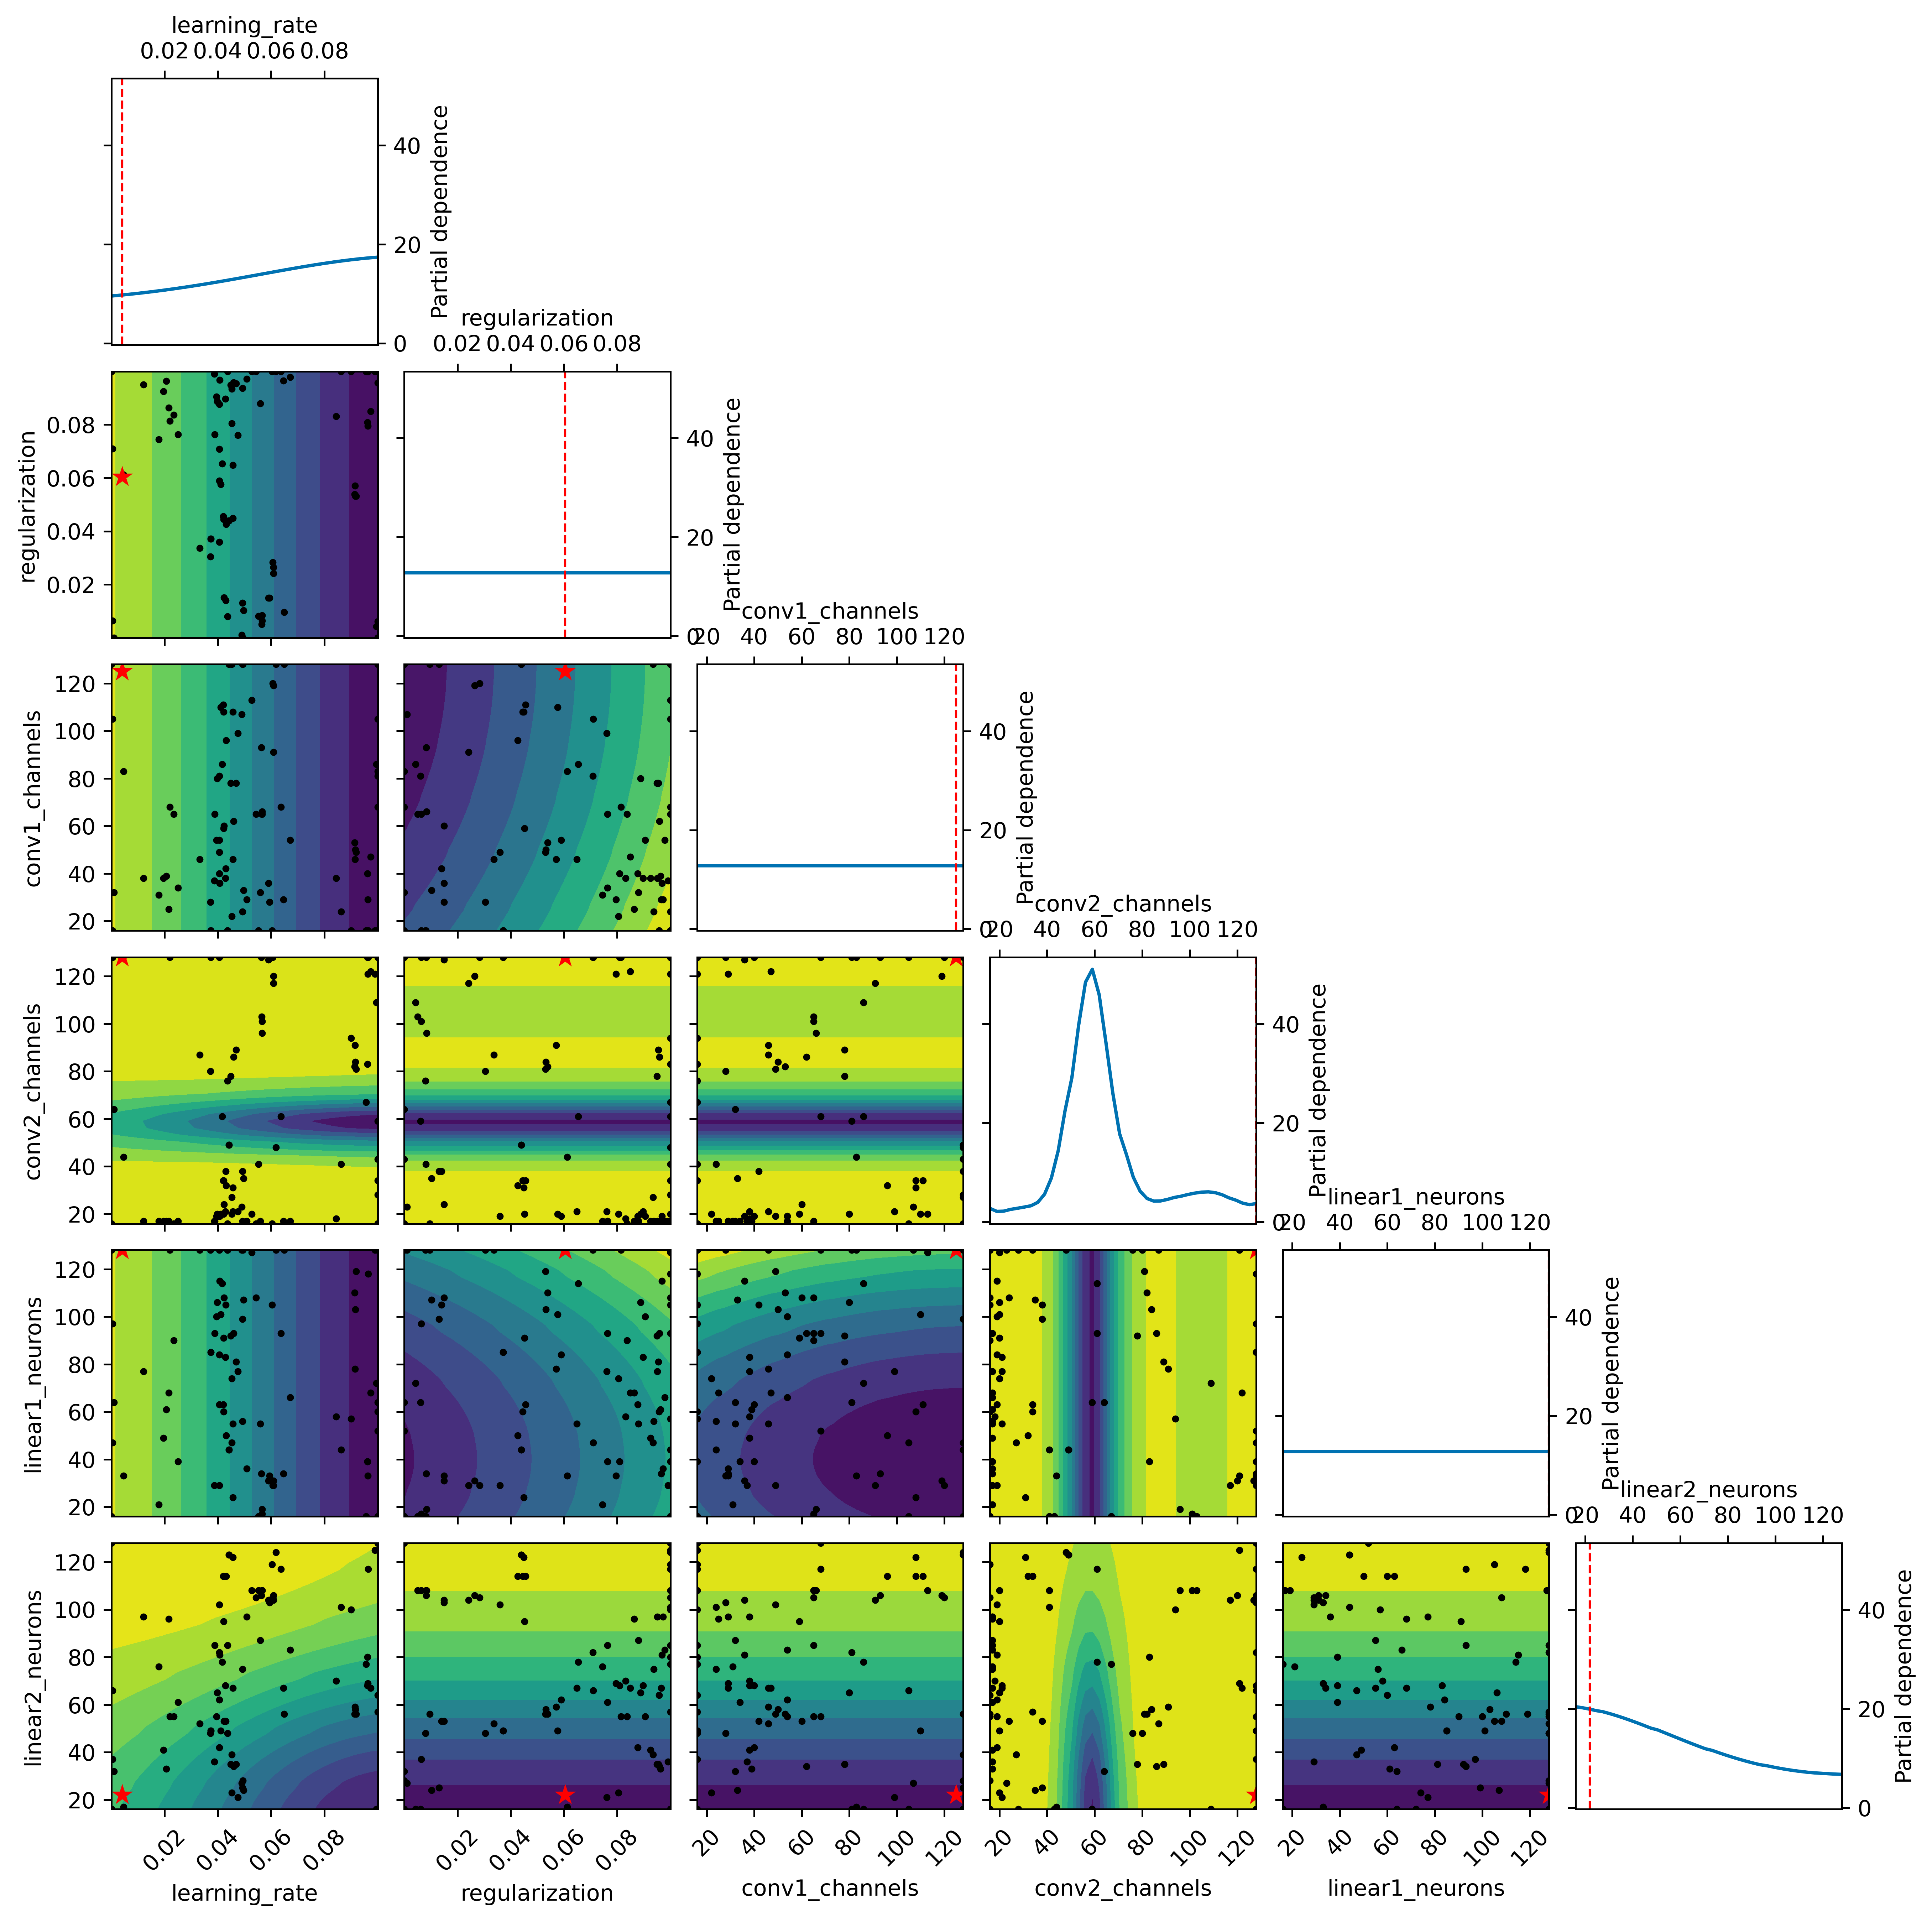

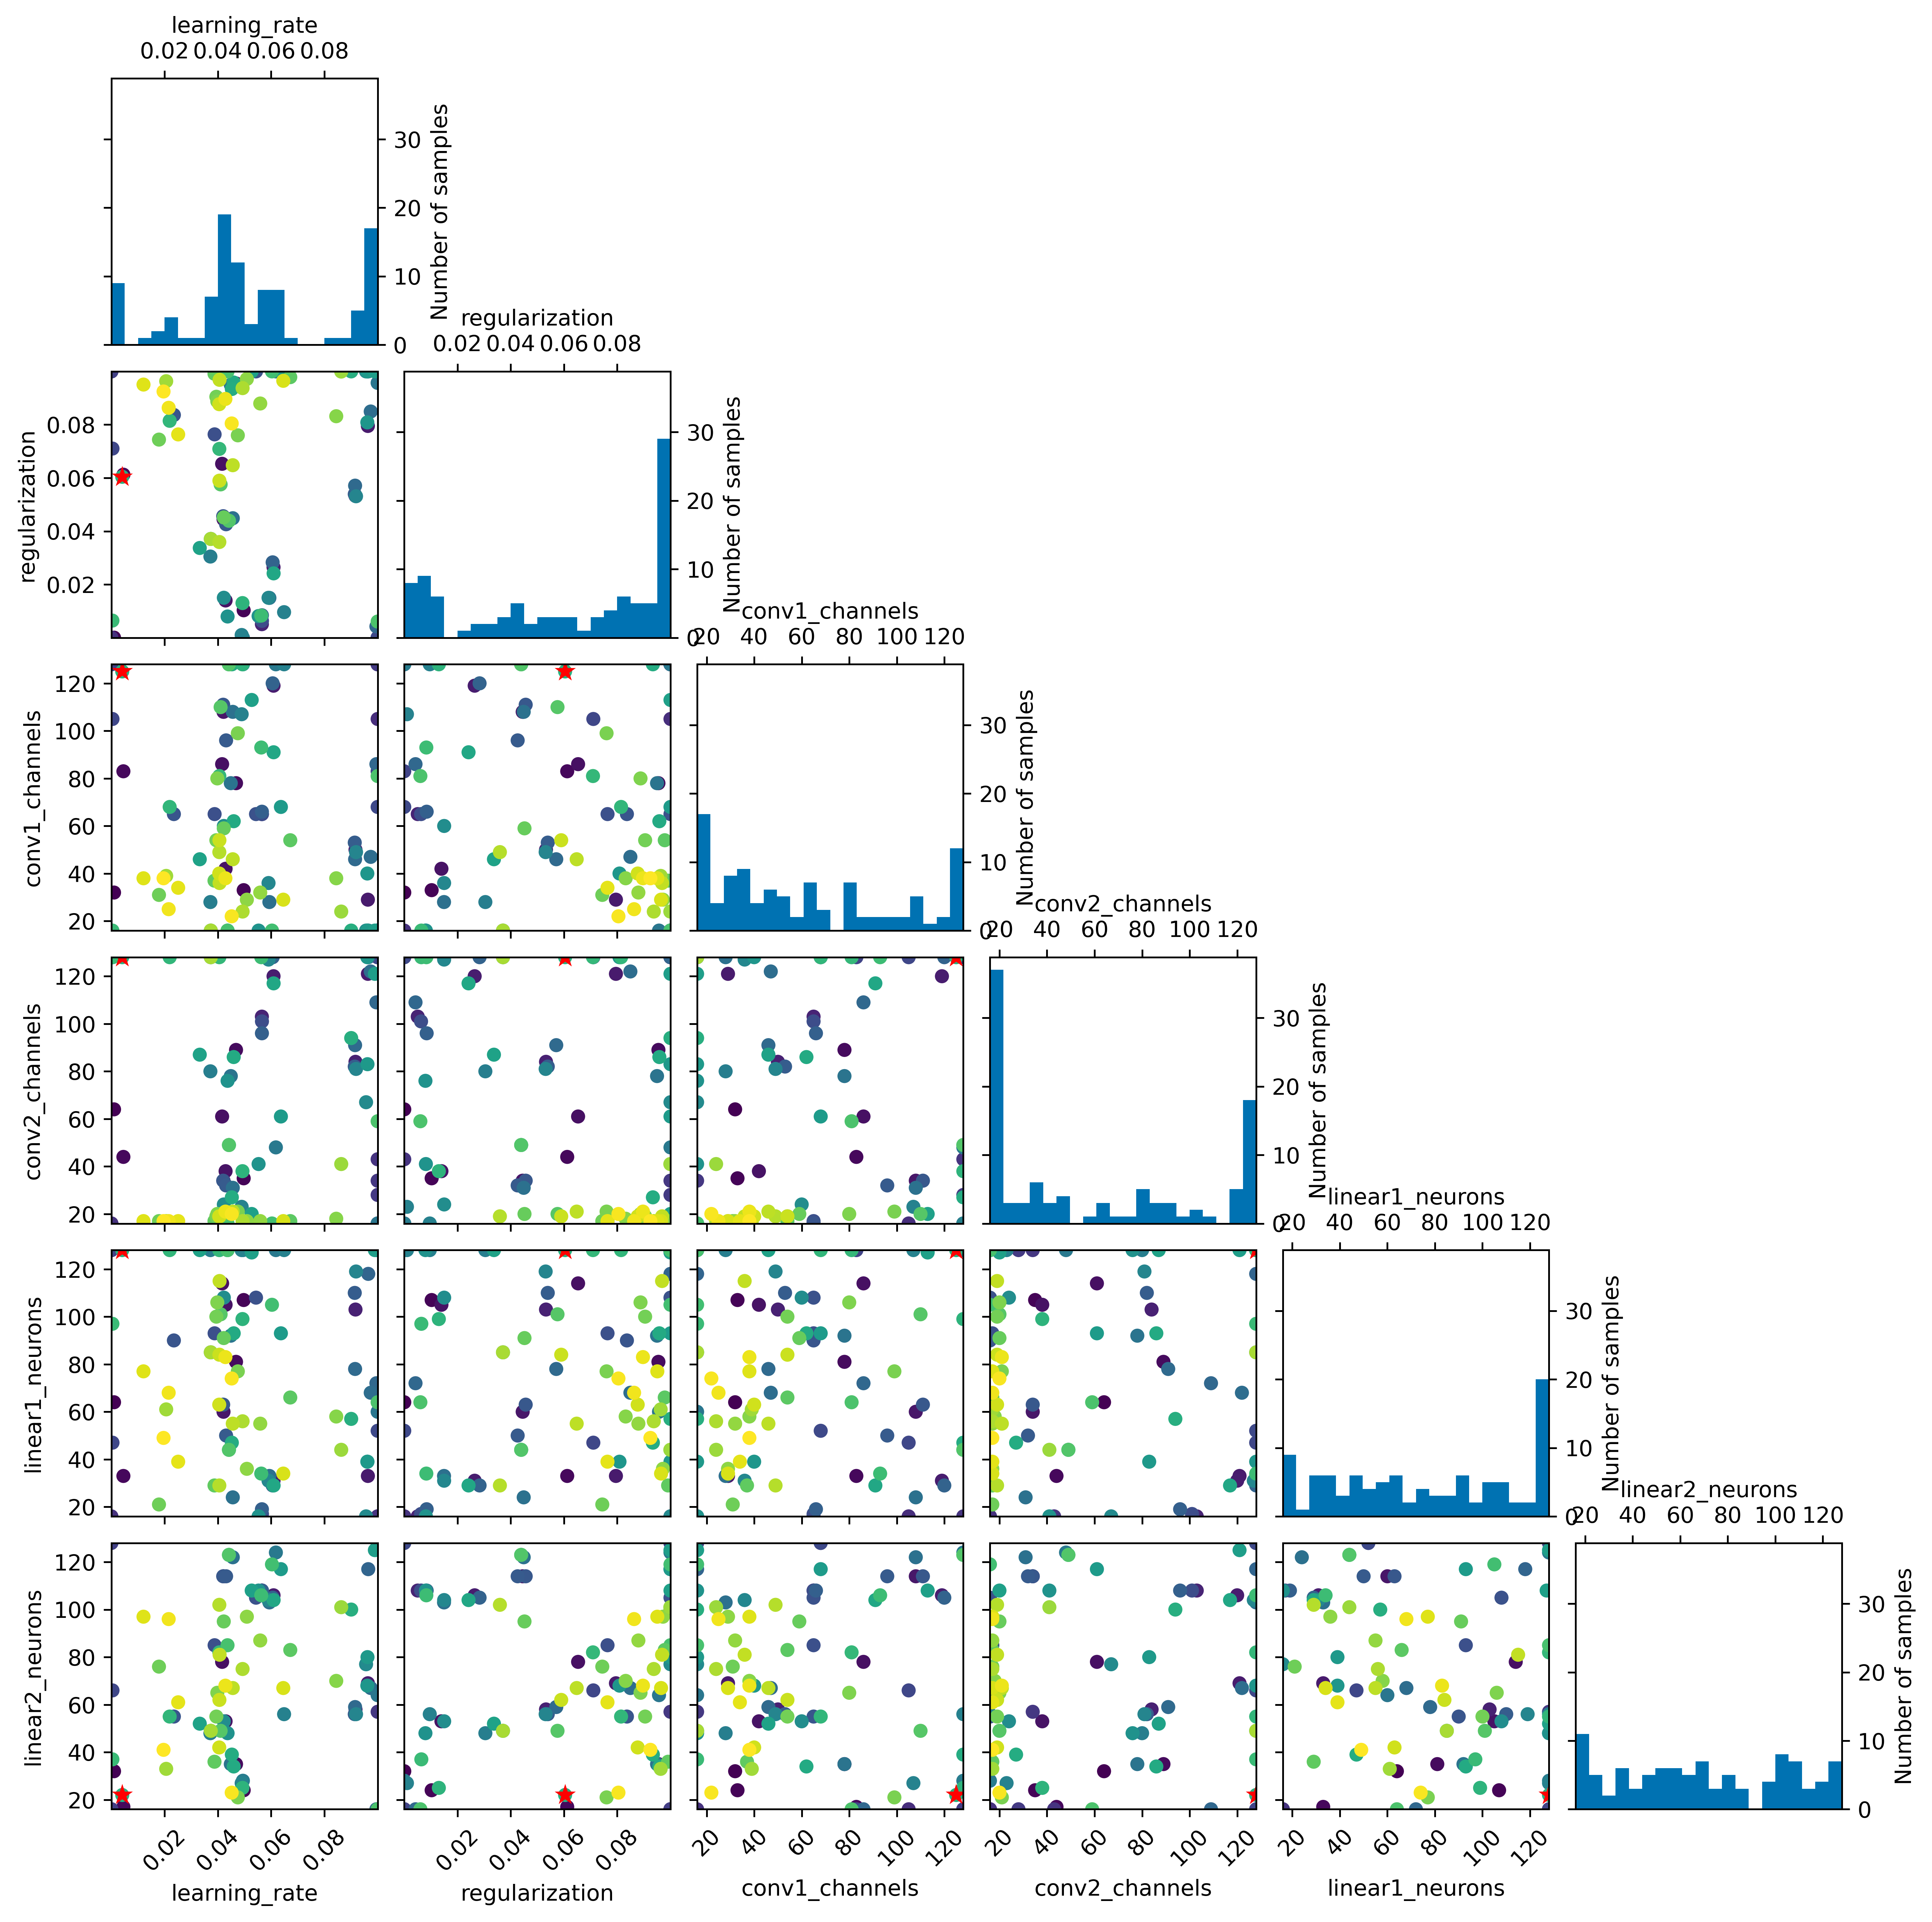

In [40]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
# sourcery skip: merge-list-append
space = []
space.append(Real(1e-5, 1e-1, name="learning_rate"))
space.append(Real(1e-10, 1e-1, name="regularization"))
space.append(Integer(16, 128, name="conv1_channels"))
space.append(Integer(16, 128, name="conv2_channels"))
space.append(Integer(16, 128, name="linear1_neurons"))
space.append(Integer(16, 128, name="linear2_neurons"))

# Set default hyperparameters
default_params = [1e-3, 1e-5, 32, 64, 64, 32]

batch_size = 128
activation = nn.ReLU()

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, conv1_channels, conv2_channels, linear1_neurons, linear2_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    model = CNN(
        conv1_channels=conv1_channels,
        conv2_channels=conv2_channels,
        linear1_neurons=linear1_neurons,
        linear2_neurons=linear2_neurons,
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(dataset=kfold_data, model=model, optimizer=optimizer, batch_size=batch_size)
    # print(f'Avg. best validation loss: {sum(best_losses)/n_splits}')

    return avg_best_loss


n_calls = 100
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(
    func=fitness,
    x0=default_params,
    dimensions=space,
    n_calls=n_calls,
    random_state=SEED,
    verbose=True,
    callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process")],
)

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x